<a href="https://colab.research.google.com/github/LamNg99/Intelligent-Systems/blob/main/Lam_Nguyen_Lab_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab  #2

First and Last Name: Lam Nguyen

Student ID: 500838417

Video URL: -----------------------

# Gradient Descent For Logistic Regression
This notebook looks into Python_based codes in attempt to implement Gradient Descent for solving a logistic regression problem. The overall goal aims to builds a machine learning model capable of predicting whether or not someone has coronary heart disease based on their medical attributes using the [heart data set](https://raw.githubusercontent.com/tofighi/MachineLearning/master/datasets/heart.csv) taken from a larger dataset, described in Rousseauw et al, 1983, South African Medical Journal.

In [14]:
# Regular EDA (exploratory data analysis) and plotting libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Models from Scikit-Learn
from sklearn.linear_model import LogisticRegression

## Data preparation and EDA
The following are the features we'll use to predict our target variable (heart disease or no heart disease).
1. sbp - systolic blood pressure
2. tobacco - cumulative tobacco (kg)
3. ldl - low densiity lipoprotein cholesterol
4. adiposity
5. famhist - family history of heart disease (Present, Absent)
6. typea - type-A behavior
7. obesity
8. alcohol - current alcohol consumption
9. age - age at onset
10. chd (target) - have coronary heart disease or not (1=yes, 0=no) (= the predicted attribute)

**Note:** No personal identifiable information (PPI) can be found in the dataset.

In [15]:
# Load data
df = pd.read_csv('https://raw.githubusercontent.com/tofighi/MachineLearning/master/datasets/heart.csv')
df.shape # (rows, columns)

(462, 11)

In [16]:
# Drop unneccessary column
df.drop('row.names', axis=1, inplace=True)

In [17]:
df.head()

,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,160,12.00,5.73,23.11,Present,49,25.30,97.20,52,1
1,144,0.01,4.41,28.61,Absent,55,28.87,2.06,63,1
2,118,0.08,3.48,32.28,Present,52,29.14,3.81,46,0
3,170,7.50,6.41,38.03,Present,51,31.99,24.26,58,1
4,134,13.60,3.50,27.78,Present,60,25.99,57.34,49,1


In [18]:
# Find out how many of each class 
df['chd'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

0    65.4%
1    34.6%
Name: chd, dtype: object

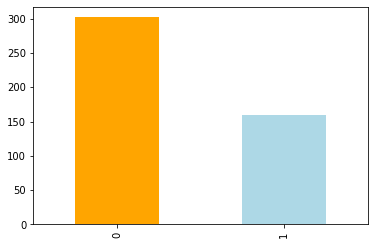

In [19]:
df['chd'].value_counts().plot(kind='bar', color=['orange','lightblue']);

In [20]:
# Check for missing value
df.isna().sum()

sbp          0
tobacco      0
ldl          0
adiposity    0
famhist      0
typea        0
obesity      0
alcohol      0
age          0
chd          0
dtype: int64

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 462 entries, 0 to 461
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sbp        462 non-null    int64  
 1   tobacco    462 non-null    float64
 2   ldl        462 non-null    float64
 3   adiposity  462 non-null    float64
 4   famhist    462 non-null    object 
 5   typea      462 non-null    int64  
 6   obesity    462 non-null    float64
 7   alcohol    462 non-null    float64
 8   age        462 non-null    int64  
 9   chd        462 non-null    int64  
dtypes: float64(5), int64(4), object(1)
memory usage: 36.2+ KB


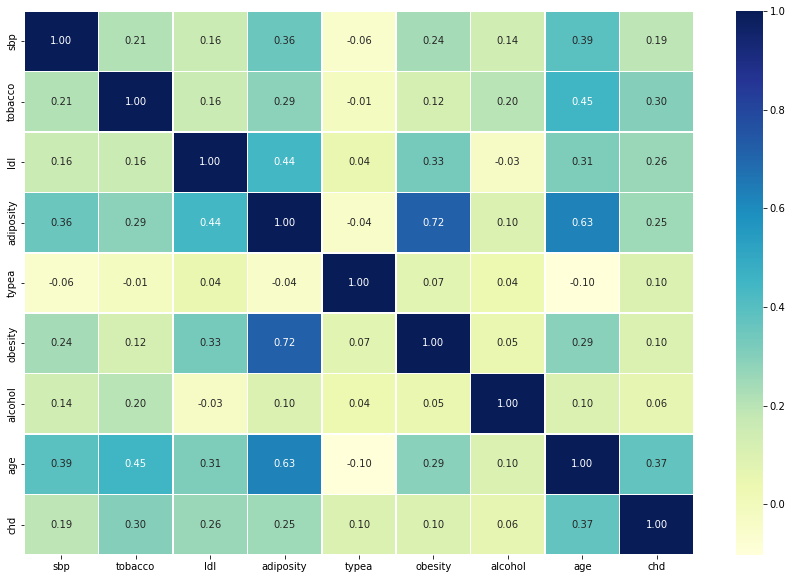

In [22]:
# Make the correlation matrix more visualization
corr_matrix = df.corr()
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.heatmap(corr_matrix,
                annot=True,
                linewidths=0.5,
                fmt='.2f',
                cmap='YlGnBu');

## Implementation steps

### Standardization
Standardization typically means rescales data to have a mean of 0 and a standard deviation of 1 (unit variance). This method is widely used for normalization in many machine learning algorithms as follows:

$$ x^{'} = \frac{x-\bar{x}}{\sigma} $$

In [23]:
def preprocess(data):
  for col in data:
    if data[col].dtype == 'object':
      data = pd.get_dummies(data, columns=[col], drop_first=True)
    else:
      data[col] = (data[col] - data[col].mean()) / data[col].std()
  return data

### Sigmoid function
$$ S(z) = P(y=1|x) = h_{\theta}{(x)} = \frac{1}{1 + exp(-\theta^Tx)} \equiv \sigma(\theta^Tx) = \frac{1}{1+e^{-z}} $$ 

where $ z = \theta^Tx $.

In [24]:
def hypothesis(X, theta):
  z = X.dot(theta.T)
  return 1/(1 + np.exp(-z))

### Cost function
**Binary cross-entropy** is a loss function designed for **binary classification** problems, where the classifier can return the predicted probabilities of the positive class. The binary cross-entropy is defined as:

$$ J(\theta) = -\frac{1}{m}\sum^{m}_{i}(y^{(i)}log(h_{\theta}(x^{(i)})) + (1-y^{(i)})log(1-h_{\theta}(x^{(i)}))) $$

where $y^{(i)}$ is the target variable (can only be  0  or  1 ), $x^{(i)}$ are the variables/features, and $h_{\theta}(x^{(i)})$ is the probability model of being of class  1 .

In [25]:
def cross_entropy(X, y, theta):
  m = X.shape[0]
  h = hypothesis(X, theta)
  cost = -(1/m) * np.sum((y*np.log(h)) + (1-y)*np.log(1-h))
  return cost

### Batch Gradient Descent
In Batch Gradient Descent, all the training data is taken into consideration to take a single step. The function for updating the thetas
(weights) iteratively:

$$ \theta_{new} := \theta_{old} + \alpha\times\frac{1}{m}\sum^{m}_{i=1}[y^{(i)} - \sigma(\theta^{T}_{old}(x^{(i)}))]x^{(i)}_{j} $$

In [26]:
def batch_gradient_descent(X, y, theta, learning_rate, iterations):
    m = X.shape[0]
    X_j = np.c_[np.ones((len(X), 1)), X]
    cost_history = np.zeros(iterations)
    theta_history = np.zeros((iterations, X.shape[1]+1))
    for iter in range(iterations):
        h = hypothesis(X_j, theta)
        theta = theta + (1 / m) * learning_rate * np.sum(X_j.T.dot(y - h))
        theta_history[iter, :] = theta.T
        cost_history[iter] = cross_entropy(X_j, y, theta)

        if iterations <= 1000:
          if (iter+1)%100 == 0:
            print(f'Iteration: {iter+1} ----> cost: {cost_history[iter]:.2f}')
    
        else:
          if (iter+1)%1000 == 0:
            print(f'Iteration: {iter+1} ----> cost: {cost_history[iter]:.2f}')
    return theta, cost_history, theta_history

### Mini-batch Gradient Descent
This technique uses a batch of a fixed number of training examples which is less than the actual dataset and call it a mini-batch. Doing this helps to achieve the advantages of the former variants.

In [27]:
def mini_batch_gradient_descent(X, y, theta, learning_rate, iterations, batch_size):
    m = X.shape[0]
    cost_history = np.zeros(iterations)
    for iter in range(iterations):
        cost = 0.0
        np.random.seed(42)
        shuffled_indices = np.random.permutation(m)
        X, y = X.iloc[shuffled_indices], y.iloc[shuffled_indices]
        for i in range(0, m, batch_size):
            X_i = X[i:i+batch_size]
            y_i = y[i:i+batch_size]
            X_j = np.c_[np.ones(len(X_i)),X_i]
            h = hypothesis(X_j, theta)
            theta = theta + (1 / m) * learning_rate * np.sum(X_j.T.dot(y_i - h))
            cost += cross_entropy(X_j, y_i, theta)
        cost_history[iter] = cost

        if iterations <= 1000:
          if (iter+1)%100 == 0:
            print(f'Iteration: {iter+1} ----> cost: {cost_history[iter]:.2f}')
    
        else:
          if (iter+1)%1000 == 0:
            print(f'Iteration: {iter+1} ----> cost: {cost_history[iter]:.2f}')
    return theta, cost_history

## Performing Gradient Descent for Linear Regression

### Data preprocessing

In [28]:
# Split data into X and y
X = df.drop('chd', axis=1)
y = df['chd']

In [29]:
# Standardize and encode the categorical variable(s)
preprocessed_X = preprocess(X)
preprocessed_X.head()

,sbp,tobacco,ldl,adiposity,typea,obesity,alcohol,age,famhist_Present
0,1.057417,1.821099,0.477894,-0.295183,-0.418017,-0.176594,3.274189,0.628654,1
1,0.276789,-0.789382,-0.159507,0.411694,0.193134,0.670646,-0.612081,1.381617,0
2,-0.991731,-0.774141,-0.608585,0.883374,-0.112441,0.734723,-0.540597,0.217947,1
3,1.545310,0.841352,0.806252,1.622382,-0.214300,1.411091,0.294742,1.039361,1
4,-0.211103,2.169453,-0.598928,0.305020,0.702427,-0.012842,1.645991,0.423301,1


In [30]:
preprocessed_X.describe().round(2)

,sbp,tobacco,ldl,adiposity,typea,obesity,alcohol,age,famhist_Present
count,462.00,462.00,462.00,462.00,462.00,462.00,462.00,462.00,462.00
mean,-0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.42
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.49
min,-1.82,-0.79,-1.82,-2.40,-4.08,-2.69,-0.70,-1.90,0.00
25%,-0.70,-0.78,-0.70,-0.72,-0.62,-0.73,-0.68,-0.81,0.00
50%,-0.21,-0.36,-0.19,0.09,-0.01,-0.06,-0.39,0.15,0.00
75%,0.47,0.41,0.51,0.75,0.70,0.58,0.28,0.83,1.00
max,3.89,6.00,5.11,2.20,2.54,4.87,5.32,1.45,1.00


### Initialize parameters

In [31]:
np.random.seed(42)

theta = np.random.uniform(0, 1, X.shape[1] + 1)
small_alpha = 0.0001
large_alpha = 0.001
batch_size = 50

### Batch Gradient Descent iteration

In [32]:
%%time
# Perform with learning rate = 0.0001 and 500 iterations
small_theta_500, small_cost_history_500, _ = batch_gradient_descent(X=preprocessed_X, y=y, theta=theta, learning_rate=small_alpha, iterations=500)

Iteration: 100 ----> cost: 0.87
Iteration: 200 ----> cost: 0.86
Iteration: 300 ----> cost: 0.86
Iteration: 400 ----> cost: 0.85
Iteration: 500 ----> cost: 0.84
CPU times: user 454 ms, sys: 8.44 ms, total: 463 ms
Wall time: 464 ms


In [33]:
%%time
# Perform with learning rate = 0.0001 and 1000 iterations
small_theta_1000, small_cost_history_1000, _ = batch_gradient_descent(X=preprocessed_X, y=y, theta=theta, learning_rate=small_alpha, iterations=1000)

Iteration: 100 ----> cost: 0.87
Iteration: 200 ----> cost: 0.86
Iteration: 300 ----> cost: 0.86
Iteration: 400 ----> cost: 0.85
Iteration: 500 ----> cost: 0.84
Iteration: 600 ----> cost: 0.84
Iteration: 700 ----> cost: 0.83
Iteration: 800 ----> cost: 0.82
Iteration: 900 ----> cost: 0.82
Iteration: 1000 ----> cost: 0.81
CPU times: user 739 ms, sys: 12.8 ms, total: 752 ms
Wall time: 740 ms


In [34]:
%%time
# Perform with learning rate = 0.0001 and 10000 iterations
small_theta_10000, small_cost_history_10000, _ = batch_gradient_descent(X=preprocessed_X, y=y, theta=theta, learning_rate=small_alpha, iterations=10000)

Iteration: 1000 ----> cost: 0.81
Iteration: 2000 ----> cost: 0.76
Iteration: 3000 ----> cost: 0.73
Iteration: 4000 ----> cost: 0.71
Iteration: 5000 ----> cost: 0.70
Iteration: 6000 ----> cost: 0.70
Iteration: 7000 ----> cost: 0.70
Iteration: 8000 ----> cost: 0.69
Iteration: 9000 ----> cost: 0.69
Iteration: 10000 ----> cost: 0.69
CPU times: user 7.06 s, sys: 37.2 ms, total: 7.09 s
Wall time: 7.06 s


In [35]:
%%time
# Perform with learning rate = 0.001 and 500 iterations
large_theta_500, large_cost_history_500, _ = batch_gradient_descent(X=preprocessed_X, y=y, theta=theta, learning_rate=large_alpha, iterations=500)

Iteration: 100 ----> cost: 0.81
Iteration: 200 ----> cost: 0.76
Iteration: 300 ----> cost: 0.73
Iteration: 400 ----> cost: 0.71
Iteration: 500 ----> cost: 0.70
CPU times: user 376 ms, sys: 3.5 ms, total: 380 ms
Wall time: 378 ms


In [36]:
%%time
# Perform with learning rate = 0.001 and 1000 iterations
large_theta_1000, large_cost_history_1000, _ = batch_gradient_descent(X=preprocessed_X, y=y, theta=theta, learning_rate=large_alpha, iterations=1000)

Iteration: 100 ----> cost: 0.81
Iteration: 200 ----> cost: 0.76
Iteration: 300 ----> cost: 0.73
Iteration: 400 ----> cost: 0.71
Iteration: 500 ----> cost: 0.70
Iteration: 600 ----> cost: 0.70
Iteration: 700 ----> cost: 0.70
Iteration: 800 ----> cost: 0.69
Iteration: 900 ----> cost: 0.69
Iteration: 1000 ----> cost: 0.69
CPU times: user 750 ms, sys: 14.5 ms, total: 765 ms
Wall time: 774 ms


In [37]:
%%time
# Perform with learning rate = 0.001 and 10000 iterations
large_theta_10000, large_cost_history_10000, _ = batch_gradient_descent(X=preprocessed_X, y=y, theta=theta, learning_rate=large_alpha, iterations=10000)

Iteration: 1000 ----> cost: 0.69
Iteration: 2000 ----> cost: 0.69
Iteration: 3000 ----> cost: 0.69
Iteration: 4000 ----> cost: 0.69
Iteration: 5000 ----> cost: 0.69
Iteration: 6000 ----> cost: 0.69
Iteration: 7000 ----> cost: 0.69
Iteration: 8000 ----> cost: 0.69
Iteration: 9000 ----> cost: 0.69
Iteration: 10000 ----> cost: 0.69
CPU times: user 8.67 s, sys: 36.2 ms, total: 8.71 s
Wall time: 8.82 s


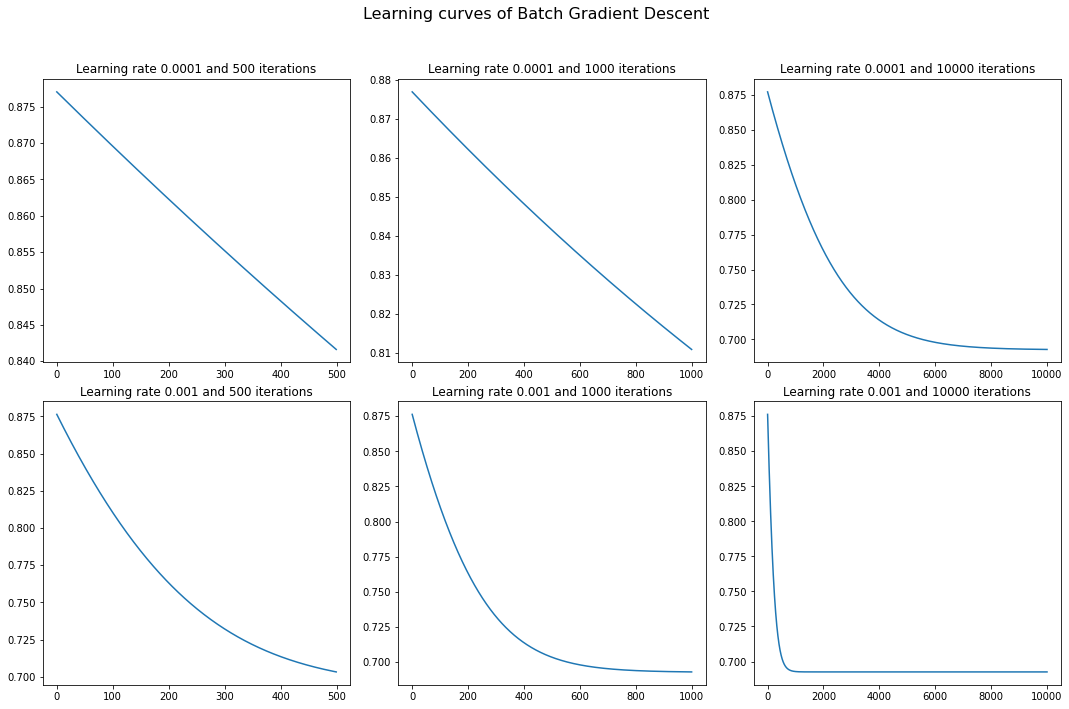

In [38]:
# Plot the learning curves
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.plot(small_cost_history_500)
plt.title('Learning rate 0.0001 and 500 iterations')

plt.subplot(2, 3, 2)
plt.plot(small_cost_history_1000)
plt.title('Learning rate 0.0001 and 1000 iterations')

plt.subplot(2, 3, 3)
plt.plot(small_cost_history_10000)
plt.title('Learning rate 0.0001 and 10000 iterations')

plt.subplot(2, 3, 4) 
plt.plot(large_cost_history_500)
plt.title('Learning rate 0.001 and 500 iterations')

plt.subplot(2, 3, 5)
plt.plot(large_cost_history_1000)
plt.title('Learning rate 0.001 and 1000 iterations')

plt.subplot(2, 3, 6)
plt.plot(large_cost_history_10000)
plt.title('Learning rate 0.001 and 10000 iterations')

plt.tight_layout(h_pad=1.0)
plt.suptitle('Learning curves of Batch Gradient Descent', fontsize=16)
plt.subplots_adjust(top=0.88)
plt.show()

In **Batch Gradient Descent**, all the training data is taken into consideration to take a single step. We take the average of the gradients of all the training examples and then use that mean gradient to update our parameters. So that’s just one step of gradient descent in one iteration. The graph of cost vs iterations is also quite smooth because we are averaging over all the gradients of training data for a single step. We observe that the cost keeps on decreasing over the iterations.

### Mini-batch Gradient Descent iteration

In [39]:
%%time
# Perform with learning rate = 0.0001 and 500 iterations
small_theta_mini_500, small_cost_history_mini_500 = mini_batch_gradient_descent(X=preprocessed_X, y=y, theta=theta, learning_rate=small_alpha, iterations=500, batch_size=batch_size)

Iteration: 100 ----> cost: 9.15
Iteration: 200 ----> cost: 8.70
Iteration: 300 ----> cost: 8.68
Iteration: 400 ----> cost: 8.50
Iteration: 500 ----> cost: 8.34
CPU times: user 5.46 s, sys: 113 ms, total: 5.58 s
Wall time: 5.86 s


In [40]:
%%time
# Perform with learning rate = 0.0001 and 1000 iterations
small_theta_mini_1000, small_cost_history_mini_1000 = mini_batch_gradient_descent(X=preprocessed_X, y=y, theta=theta, learning_rate=small_alpha, iterations=1000, batch_size=batch_size)

Iteration: 100 ----> cost: 9.15
Iteration: 200 ----> cost: 8.70
Iteration: 300 ----> cost: 8.68
Iteration: 400 ----> cost: 8.50
Iteration: 500 ----> cost: 8.34
Iteration: 600 ----> cost: 8.68
Iteration: 700 ----> cost: 8.26
Iteration: 800 ----> cost: 8.28
Iteration: 900 ----> cost: 8.56
Iteration: 1000 ----> cost: 8.35
CPU times: user 11.5 s, sys: 171 ms, total: 11.6 s
Wall time: 12.1 s


In [41]:
%%time
# Perform with learning rate = 0.0001 and 10000 iterations
small_theta_mini_10000, small_cost_history_mini_10000 = mini_batch_gradient_descent(X=preprocessed_X, y=y, theta=theta, learning_rate=small_alpha, iterations=10000, batch_size=batch_size)

Iteration: 1000 ----> cost: 8.35
Iteration: 2000 ----> cost: 7.69
Iteration: 3000 ----> cost: 7.52
Iteration: 4000 ----> cost: 7.09
Iteration: 5000 ----> cost: 7.38
Iteration: 6000 ----> cost: 6.89
Iteration: 7000 ----> cost: 6.89
Iteration: 8000 ----> cost: 7.00
Iteration: 9000 ----> cost: 7.06
Iteration: 10000 ----> cost: 6.96
CPU times: user 1min 55s, sys: 1.62 s, total: 1min 56s
Wall time: 1min 56s


In [42]:
%%time
# Perform with learning rate = 0.001 and 500 iterations
large_theta_mini_500, large_cost_history_mini_500 = mini_batch_gradient_descent(X=preprocessed_X, y=y, theta=theta, learning_rate=large_alpha, iterations=500, batch_size=batch_size)

Iteration: 100 ----> cost: 8.51
Iteration: 200 ----> cost: 7.67
Iteration: 300 ----> cost: 7.36
Iteration: 400 ----> cost: 7.12
Iteration: 500 ----> cost: 6.92
CPU times: user 6.51 s, sys: 67.9 ms, total: 6.58 s
Wall time: 6.7 s


In [43]:
%%time
# Perform with learning rate = 0.001 and 1000 iterations
large_theta_mini_1000, large_cost_history_mini_1000 = mini_batch_gradient_descent(X=preprocessed_X, y=y, theta=theta, learning_rate=large_alpha, iterations=1000, batch_size=batch_size)

Iteration: 100 ----> cost: 8.51
Iteration: 200 ----> cost: 7.67
Iteration: 300 ----> cost: 7.36
Iteration: 400 ----> cost: 7.12
Iteration: 500 ----> cost: 6.92
Iteration: 600 ----> cost: 7.16
Iteration: 700 ----> cost: 6.81
Iteration: 800 ----> cost: 6.84
Iteration: 900 ----> cost: 7.17
Iteration: 1000 ----> cost: 6.97
CPU times: user 11.7 s, sys: 225 ms, total: 11.9 s
Wall time: 11.7 s


In [44]:
%%time
# Perform with learning rate = 0.001 and 10000 iterations
large_theta_mini_10000, large_cost_history_mini_10000 = mini_batch_gradient_descent(X=preprocessed_X, y=y, theta=theta, learning_rate=large_alpha, iterations=10000, batch_size=batch_size)

Iteration: 1000 ----> cost: 6.97
Iteration: 2000 ----> cost: 6.88
Iteration: 3000 ----> cost: 7.01
Iteration: 4000 ----> cost: 6.87
Iteration: 5000 ----> cost: 7.17
Iteration: 6000 ----> cost: 6.82
Iteration: 7000 ----> cost: 6.86
Iteration: 8000 ----> cost: 6.97
Iteration: 9000 ----> cost: 7.04
Iteration: 10000 ----> cost: 6.95
CPU times: user 1min 53s, sys: 1.39 s, total: 1min 55s
Wall time: 1min 54s


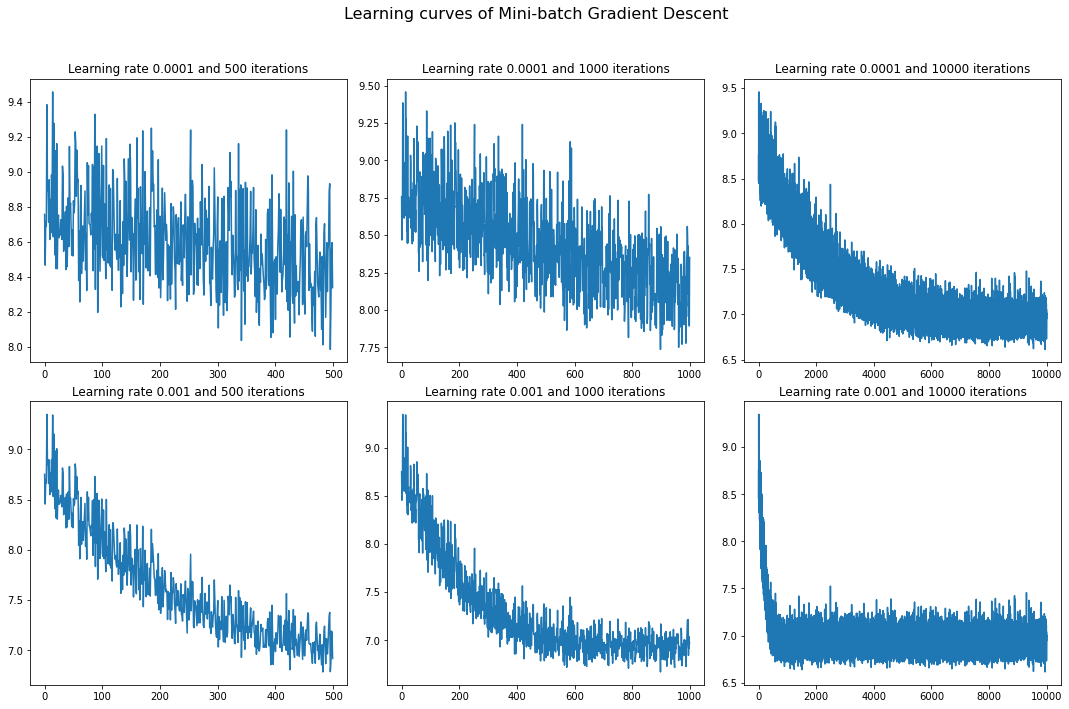

In [45]:
# Plot the learning curves
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.plot(small_cost_history_mini_500)
plt.title('Learning rate 0.0001 and 500 iterations')

plt.subplot(2, 3, 2)
plt.plot(small_cost_history_mini_1000)
plt.title('Learning rate 0.0001 and 1000 iterations')

plt.subplot(2, 3, 3)
plt.plot(small_cost_history_mini_10000)
plt.title('Learning rate 0.0001 and 10000 iterations')

plt.subplot(2, 3, 4) 
plt.plot(large_cost_history_mini_500)
plt.title('Learning rate 0.001 and 500 iterations')

plt.subplot(2, 3, 5)
plt.plot(large_cost_history_mini_1000)
plt.title('Learning rate 0.001 and 1000 iterations')

plt.subplot(2, 3, 6)
plt.plot(large_cost_history_mini_10000)
plt.title('Learning rate 0.001 and 10000 iterations')

plt.tight_layout(h_pad=1.0)
plt.suptitle('Learning curves of Mini-batch Gradient Descent', fontsize=16)
plt.subplots_adjust(top=0.88)
plt.show()

In **Mini-batch Gradient Descent**, we use a batch of a fixed number of training examples which is less than the actual dataset and call it a mini-batch. Doing this helps us achieve the advantages of both the former variants we saw. The average cost over the iterations in mini-batch gradient descent fluctuates because we are averaging a small number of examples at a time. So, when we are using the mini-batch gradient descent we are updating our parameters frequently as well as we can use vectorized implementation for faster computations.

## Logistic Regression using Scikit-Learn 

In [46]:
X_train = np.c_[np.ones((len(preprocessed_X), 1)), preprocessed_X]

In [47]:
# Innitiallize model
clf = LogisticRegression()

# Fit the data into the model
clf.fit(X_train, y)

LogisticRegression()

In [48]:
coef_dict = {
    'Logistic Regression': clf.coef_[0].round(2),
    'Batch Gradient Descent': large_theta_10000.round(2),
    'Mini-batch Gradient Descent': large_theta_mini_10000.round(2)
}

In [49]:
coefficients = pd.DataFrame(coef_dict, index = ['theta0'] + list(preprocessed_X.columns))
coefficients.T

,theta0,sbp,tobacco,ldl,adiposity,typea,obesity,alcohol,age,famhist_Present
Logistic Regression,-0.00,0.13,0.36,0.36,0.14,0.38,-0.26,0.00,0.65,0.88
Batch Gradient Descent,0.02,0.59,0.37,0.24,-0.20,-0.20,-0.30,0.51,0.24,0.35
Mini-batch Gradient Descent,0.02,0.59,0.37,0.24,-0.20,-0.20,-0.30,0.51,0.24,0.35


In some cases the magnitude of the weights can provide information about the feature importance in a logistic regression model. Features with larger absolute weights tend to have a greater impact on the prediction output. This is because the magnitude of the weight indicates the contribution of the corresponding feature to the dot product that computes the model's prediction.

However, it's important to keep in mind that the relationship between feature importance and weight magnitude can be affected by the scaling of the input features. For example, if a feature is scaled by a large factor, its corresponding weight will also be large, even if the feature is not particularly important.

Additionally, it's important to note that the interpretation of feature importance based on weight magnitude is not always straightforward, especially in cases where the features are highly correlated with each other. In such cases, the magnitude of the weights might not accurately reflect the feature importance.

Overall, the relationship between weight magnitude and feature importance can provide useful information, but it should be considered in conjunction with other methods for evaluating feature importance, such as feature selection or feature importance from an ensemble of models.